In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
import torch.optim as optim
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch_geometric.data import Data
from torch_geometric.nn import ARMAConv
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss
)

/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/snu/an

In [2]:
# === Load Patients ===
fa_patients_path = "/home/snu/Downloads/NIFD_Patients_FA_Histogram_Feature.npy"
Patients_FA_array = np.load(fa_patients_path, allow_pickle=True)

# === Load Controls ===
fa_controls_path = "/home/snu/Downloads/NIFD_Control_FA_Histogram_Feature.npy"
Controls_FA_array = np.load(fa_controls_path, allow_pickle=True)

print("Patients Shape:", Patients_FA_array.shape)
print("Controls Shape:", Controls_FA_array.shape)

# === Combine features and labels ===
X = np.vstack([Controls_FA_array, Patients_FA_array])
y = np.hstack([
    np.zeros(Controls_FA_array.shape[0], dtype=np.int64),  # 0 = Control
    np.ones(Patients_FA_array.shape[0], dtype=np.int64)    # 1 = Patient
])

# Shuffle
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

Patients Shape: (98, 180)
Controls Shape: (48, 180)


In [3]:
class ARMA_SemiSupervised(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, device, activ="SELU"):
        super(ARMA_SemiSupervised, self).__init__()
        self.device = device
        self.conv1 = ARMAConv(input_dim, hidden_dim, num_stacks=1, num_layers=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

        activations = {
            "SELU": nnFn.selu,
            "SiLU": nnFn.silu,
            "GELU": nnFn.gelu,
            "RELU": nnFn.relu,
            "ELU": nnFn.elu
        }
        self.act = activations.get(activ, nnFn.elu)

    def forward(self, data):
      x, edge_index = data.x, data.edge_index
      x_in = x
      x = self.conv1(x, edge_index)
      x = self.bn1(x)

      if x_in.shape[1] == x.shape[1]:
          x = x + x_in  # residual (skip) connection is added

      x = self.act(x)
      x = self.dropout(x)
      logits = self.fc(x)
      return logits

    def modularity_loss(self, A, logits):
        S = nnFn.softmax(logits, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.outer(d, d) / (2 * m)

        modularity_term = (-1 / (2 * m)) * torch.trace(S.T @ B @ S)
        # Collapse regularization
        I_S = torch.eye(S.shape[1], device=self.device)
        k = torch.norm(I_S)
        n = S.shape[0]
        collapse_reg = (torch.sqrt(k) / n) * torch.norm(torch.sum(S, dim=0), p='fro') - 1
        entropy_reg = -torch.mean(torch.sum(S * torch.log(S + 1e-9), dim=1))
        return modularity_term + 0.1*collapse_reg + 0.01*entropy_reg

In [4]:
def create_adj(F, alpha=1):
    F_norm = F / np.linalg.norm(F, axis=1, keepdims=True)
    W = np.dot(F_norm, F_norm.T)
    W = np.where(W >= alpha, 1, 0).astype(np.float32)
    W = W / W.max()
    return W

def load_data(adj, node_feats):
    node_feats = torch.from_numpy(node_feats).float()
    edge_index = torch.from_numpy(np.array(np.nonzero((adj > 0))))
    return Data(x=node_feats, edge_index=edge_index)

In [5]:
num_nodes, num_feats = X.shape
print(f"Number of features: {num_feats}")

Number of features: 180


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
alpha = 0.5
feats_dim = num_feats
hidden_dim = 512
num_classes = 2
num_epochs = 2000
lr = 0.0001
weight_decay = 1e-4
batch_print_freq = 100
lambda_mod = 0.01 #0.01  # weight for modularity loss
# lambda_sup = 5

In [13]:
W = create_adj(X, alpha)
data = load_data(W, X).to(device)
A_tensor = torch.from_numpy(W).float().to(device)
print(data)

Data(x=[146, 180], edge_index=[2, 21256])


In [16]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

accuracies, precisions, recalls, f1_scores, aucs, ce_losses = [], [], [], [], [], []

for fold, (train_val_idx, test_idx_global) in enumerate(sss.split(X, y), start=1):
    print(f"\n=== Fold {fold} ===")


    control_idx = np.where(y == 0)[0]
    patient_idx = np.where(y == 1)[0]

    sss_class = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=fold)
    control_train_idx, _ = next(sss_class.split(X[control_idx], y[control_idx]))
    patient_train_idx, _ = next(sss_class.split(X[patient_idx], y[patient_idx]))

    control_train = control_idx[control_train_idx]
    patient_train = patient_idx[patient_train_idx]
    train_idx_final = np.concatenate([control_train, patient_train])
    np.random.shuffle(train_idx_final)

    print(f"Train Control: {len(control_train)}, Train Patient: {len(patient_train)}")

    train_idx_t = torch.from_numpy(train_idx_final).long().to(device)
    y_train_tensor = torch.from_numpy(y[train_idx_final]).long().to(device)


    model = ARMA_SemiSupervised(feats_dim, hidden_dim, num_classes, device, "SELU").to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ce_loss = nn.CrossEntropyLoss()


    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()

        logits = model(data)
        loss_sup = ce_loss(logits[train_idx_t], y_train_tensor)
        loss_unsup = model.modularity_loss(A_tensor, logits)
        total_loss = loss_sup + lambda_mod * loss_unsup

        total_loss.backward()
        optimizer.step()

        if epoch % batch_print_freq == 0 or epoch == 1:
            model.eval()
            with torch.no_grad():
                preds_train = logits[train_idx_t].argmax(dim=1)
                acc_train = accuracy_score(y_train_tensor.cpu(), preds_train.cpu())
            print(f"Fold {fold} Epoch {epoch}: "
                  f"TotalLoss={total_loss.item():.6f} | Sup={loss_sup.item():.6f} | "
                  f"Unsup={loss_unsup.item():.6f} | TrainAcc={acc_train:.4f}")


    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1).cpu().numpy()
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()  # Probability for class 1

    y_test = y[test_idx_global]
    y_pred_test = preds[test_idx_global]
    y_prob_test = probs[test_idx_global]

    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, zero_division=0)
    rec = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    auc = roc_auc_score(y_test, y_prob_test)
    ce = log_loss(y_test, y_prob_test)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    aucs.append(auc)
    ce_losses.append(ce)

    print(f"Fold {fold} → "
          f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | "
          f"F1={f1:.4f} | AUC={auc:.4f} | CE Loss={ce:.4f}")


print("\n=== Average Results Across 20 Folds ===")
print(f"Accuracy:  {np.mean(accuracies):.4f} \u00b1 {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} \u00b1 {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} \u00b1 {np.std(recalls):.4f}")
print(f"F1-score:  {np.mean(f1_scores):.4f} \u00b1 {np.std(f1_scores):.4f}")
print(f"AUC:       {np.mean(aucs):.4f} \u00b1 {np.std(aucs):.4f}")
print(f"CE Loss:   {np.mean(ce_losses):.4f} \u00b1 {np.std(ce_losses):.4f}")


=== Fold 1 ===
Train Control: 4, Train Patient: 9
Fold 1 Epoch 1: TotalLoss=0.882351 | Sup=0.883703 | Unsup=-0.135158 | TrainAcc=0.3077
Fold 1 Epoch 100: TotalLoss=0.021980 | Sup=0.023378 | Unsup=-0.139849 | TrainAcc=1.0000
Fold 1 Epoch 200: TotalLoss=0.006308 | Sup=0.007736 | Unsup=-0.142777 | TrainAcc=1.0000
Fold 1 Epoch 300: TotalLoss=0.002705 | Sup=0.004133 | Unsup=-0.142710 | TrainAcc=1.0000
Fold 1 Epoch 400: TotalLoss=0.000988 | Sup=0.002424 | Unsup=-0.143640 | TrainAcc=1.0000
Fold 1 Epoch 500: TotalLoss=0.000258 | Sup=0.001697 | Unsup=-0.143974 | TrainAcc=1.0000
Fold 1 Epoch 600: TotalLoss=-0.000647 | Sup=0.000808 | Unsup=-0.145501 | TrainAcc=1.0000
Fold 1 Epoch 700: TotalLoss=-0.000654 | Sup=0.000806 | Unsup=-0.145936 | TrainAcc=1.0000
Fold 1 Epoch 800: TotalLoss=-0.001072 | Sup=0.000392 | Unsup=-0.146407 | TrainAcc=1.0000
Fold 1 Epoch 900: TotalLoss=-0.001140 | Sup=0.000318 | Unsup=-0.145743 | TrainAcc=1.0000
Fold 1 Epoch 1000: TotalLoss=-0.001286 | Sup=0.000188 | Unsup=-0.14

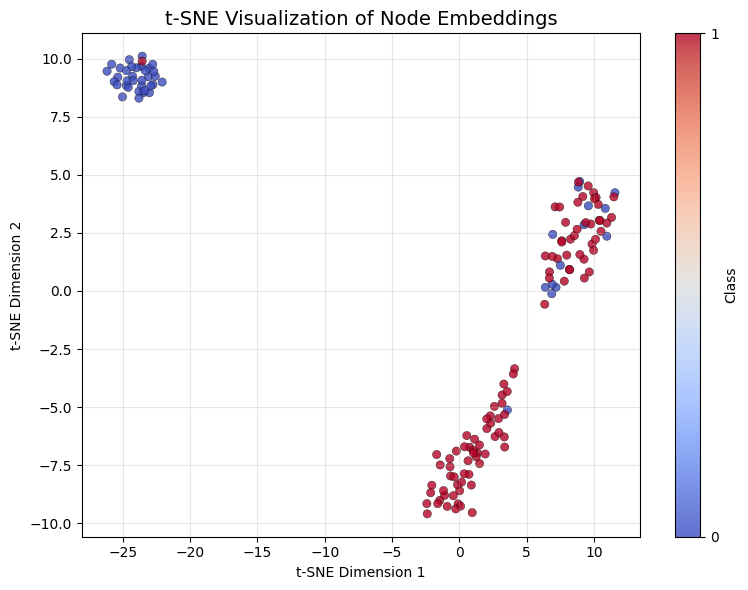

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# === t-SNE Visualization of Model Embeddings ===
model.eval()
with torch.no_grad():
    embeddings = model(data).cpu().numpy()
    labels = y  # Ground-truth labels



# Use `max_iter` instead of `n_iter` for newer sklearn versions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
emb_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    emb_2d[:, 0], emb_2d[:, 1],
    c=labels,
    cmap='coolwarm',
    alpha=0.8,
    edgecolors='k',
    linewidths=0.3
)

plt.title("t-SNE Visualization of Node Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter, ticks=[0, 1], label="Class")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


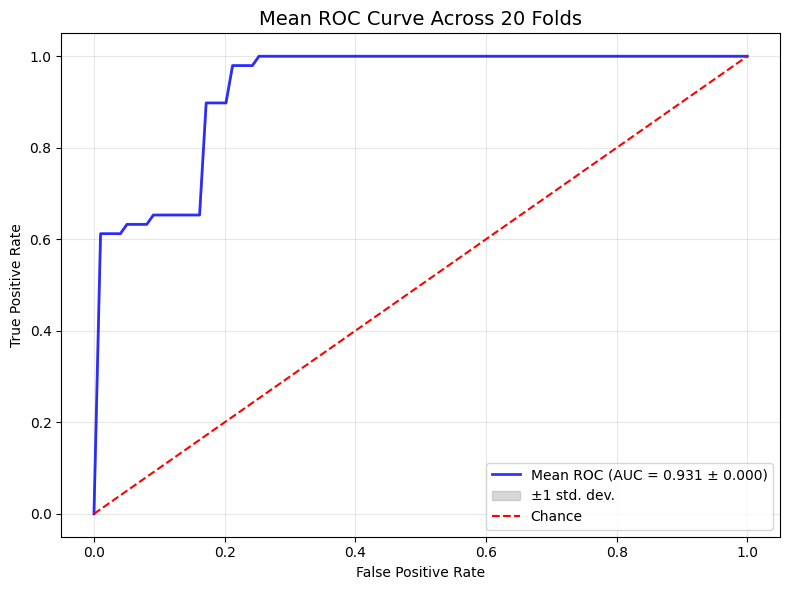

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# === Collect per-fold ROC points ===
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs_fold = []

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.5, random_state=42)

for fold, (train_val_idx, test_idx_global) in enumerate(sss.split(X, y), start=1):
    # You already have y_test and y_prob_test per fold
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)  # <-- use numpy instead of scipy
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs_fold.append(roc_auc_score(y_test, y_prob_test))

# === Compute mean and std ROC ===
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs_fold)

std_tpr = np.std(tprs, axis=0)

# === Plot ===
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b',
         label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
         lw=2, alpha=0.8)

# Shaded area for ±1 std deviation
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.3,
                 label='±1 std. dev.')

# Random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=1.5, label='Chance')

plt.title("Mean ROC Curve Across 20 Folds", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_dim = 512
num_epochs = 5000
lr = 1e-4
weight_decay = 1e-4
batch_print_freq = 500  # print every 500 epochs

# Same λ_mod list as before
lambda_mod_list = [0.001, 0.005, 0.009, 0.01, 0.05, 0.09, 0.1, 0.3, 0.5, 0.9, 1, 2, 5, 8]

# ==========================================
# Assume you already have:
# X, y, data, A_tensor, ARMA_SemiSupervised, feats_dim, num_classes
# where y=0 → control, y=1 → patient
# ==========================================

results_summary = []

# ==========================================
# Run for each λ_mod
# ==========================================
for lambda_mod in lambda_mod_list:
    print(f"\n==============================")
    print(f" Running with λ_mod = {lambda_mod}")
    print(f"==============================")

    accuracies, precisions, recalls, f1_scores, aucs, ce_losses = [], [], [], [], [], []

    sss = StratifiedShuffleSplit(n_splits=20, test_size=0.1, random_state=SEED)

    for fold, (train_val_idx, test_idx_global) in enumerate(sss.split(X, y), start=1):
        print(f"\n=== Fold {fold} ===")

        control_idx = np.where(y == 0)[0]
        patient_idx = np.where(y == 1)[0]

        sss_class = StratifiedShuffleSplit(n_splits=20, test_size=0.1, random_state=fold)
        control_train_idx, _ = next(sss_class.split(X[control_idx], y[control_idx]))
        patient_train_idx, _ = next(sss_class.split(X[patient_idx], y[patient_idx]))

        control_train = control_idx[control_train_idx]
        patient_train = patient_idx[patient_train_idx]
        train_idx_final = np.concatenate([control_train, patient_train])
        np.random.shuffle(train_idx_final)

        print(f"Train Control: {len(control_train)}, Train Patient: {len(patient_train)}")

        train_idx_t = torch.from_numpy(train_idx_final).long().to(device)
        y_train_tensor = torch.from_numpy(y[train_idx_final]).long().to(device)

        # Initialize model
        model = ARMA_SemiSupervised(feats_dim, hidden_dim, num_classes, device, "SELU").to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        ce_loss = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(1, num_epochs + 1):
            model.train()
            optimizer.zero_grad()

            logits = model(data)
            loss_sup = ce_loss(logits[train_idx_t], y_train_tensor)
            loss_unsup = model.modularity_loss(A_tensor, logits)
            total_loss = loss_sup + lambda_mod * loss_unsup

            total_loss.backward()
            optimizer.step()

            if epoch % batch_print_freq == 0 or epoch == 1:
                model.eval()
                with torch.no_grad():
                    preds_train = logits[train_idx_t].argmax(dim=1)
                    acc_train = accuracy_score(y_train_tensor.cpu(), preds_train.cpu())
                print(f"Fold {fold} Epoch {epoch}: "
                      f"TotalLoss={total_loss.item():.6f} | Sup={loss_sup.item():.6f} | "
                      f"Unsup={loss_unsup.item():.6f} | TrainAcc={acc_train:.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()  # probability for "patient"

        y_test = y[test_idx_global]
        y_pred_test = preds[test_idx_global]
        y_prob_test = probs[test_idx_global]

        acc = accuracy_score(y_test, y_pred_test)
        prec = precision_score(y_test, y_pred_test, zero_division=0)
        rec = recall_score(y_test, y_pred_test, zero_division=0)
        f1 = f1_score(y_test, y_pred_test, zero_division=0)
        auc = roc_auc_score(y_test, y_prob_test)
        ce = log_loss(y_test, y_prob_test)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        aucs.append(auc)
        ce_losses.append(ce)

        print(f"Fold {fold} → "
              f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | "
              f"F1={f1:.4f} | AUC={auc:.4f} | CE Loss={ce:.4f}")

    # Average results per λ_mod
    mean_acc, std_acc = np.mean(accuracies), np.std(accuracies)
    mean_prec, std_prec = np.mean(precisions), np.std(precisions)
    mean_rec, std_rec = np.mean(recalls), np.std(recalls)
    mean_f1, std_f1 = np.mean(f1_scores), np.std(f1_scores)
    mean_auc, std_auc = np.mean(aucs), np.std(aucs)
    mean_ce, std_ce = np.mean(ce_losses), np.std(ce_losses)

    results_summary.append({
        "λ_mod": lambda_mod,
        "Accuracy": f"{mean_acc:.4f} ± {std_acc:.4f}",
        "Precision": f"{mean_prec:.4f} ± {std_prec:.4f}",
        "Recall": f"{mean_rec:.4f} ± {std_rec:.4f}",
        "F1": f"{mean_f1:.4f} ± {std_f1:.4f}",
        "AUC": f"{mean_auc:.4f} ± {std_auc:.4f}",
        "CE Loss": f"{mean_ce:.4f} ± {std_ce:.4f}",
    })

    print(f"\n=== λ_mod = {lambda_mod} → Average Results ===")
    print(f"Accuracy:  {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Precision: {mean_prec:.4f} ± {std_prec:.4f}")
    print(f"Recall:    {mean_rec:.4f} ± {std_rec:.4f}")
    print(f"F1-score:  {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"AUC:       {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"CE Loss:   {mean_ce:.4f} ± {std_ce:.4f}")

# ==========================================
# Final summary table for all λ_mod values
# ==========================================
print("\n\n========== FINAL SUMMARY TABLE (Control vs Patient) ==========")
results_df = pd.DataFrame(results_summary)
print(results_df.to_string(index=False))


 Running with λ_mod = 0.001

=== Fold 1 ===
Train Control: 43, Train Patient: 88
Fold 1 Epoch 1: TotalLoss=0.934876 | Sup=0.935011 | Unsup=-0.135092 | TrainAcc=0.3511
Fold 1 Epoch 500: TotalLoss=0.009522 | Sup=0.009670 | Unsup=-0.147720 | TrainAcc=1.0000
Fold 1 Epoch 1000: TotalLoss=0.001366 | Sup=0.001515 | Unsup=-0.148587 | TrainAcc=1.0000
Fold 1 Epoch 1500: TotalLoss=0.000430 | Sup=0.000579 | Unsup=-0.148561 | TrainAcc=1.0000
Fold 1 Epoch 2000: TotalLoss=0.000141 | Sup=0.000289 | Unsup=-0.148651 | TrainAcc=1.0000
Fold 1 Epoch 2500: TotalLoss=0.000026 | Sup=0.000175 | Unsup=-0.148494 | TrainAcc=1.0000
Fold 1 Epoch 3000: TotalLoss=-0.000015 | Sup=0.000134 | Unsup=-0.148925 | TrainAcc=1.0000
Fold 1 Epoch 3500: TotalLoss=-0.000049 | Sup=0.000100 | Unsup=-0.148918 | TrainAcc=1.0000
Fold 1 Epoch 4000: TotalLoss=-0.000060 | Sup=0.000089 | Unsup=-0.148934 | TrainAcc=1.0000
Fold 1 Epoch 4500: TotalLoss=-0.000072 | Sup=0.000078 | Unsup=-0.149892 | TrainAcc=1.0000
Fold 1 Epoch 5000: TotalLoss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# ==========================================
# CONFIG
# ==========================================
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_dim = 512
num_epochs = 5000
lr = 1e-4
weight_decay = 1e-4
batch_print_freq = 500  # print every 500 epochs

# Same λ_mod list as before
lambda_mod_list = [0.001, 0.005, 0.009, 0.01, 0.05, 0.09, 0.1, 0.3, 0.5, 0.9, 1, 2, 5, 8]

# ==========================================
# Assume you already have:
# X, y, data, A_tensor, ARMA_SemiSupervised, feats_dim, num_classes
# where y=0 → control, y=1 → patient
# ==========================================

results_summary = []

# ==========================================
# Run for each λ_mod
# ==========================================
for lambda_mod in lambda_mod_list:
    print(f"\n==============================")
    print(f" Running with λ_mod = {lambda_mod}")
    print(f"==============================")

    accuracies, precisions, recalls, f1_scores, aucs, ce_losses = [], [], [], [], [], []

    sss = StratifiedShuffleSplit(n_splits=20, test_size=0.5, random_state=SEED)

    for fold, (train_val_idx, test_idx_global) in enumerate(sss.split(X, y), start=1):
        print(f"\n=== Fold {fold} ===")

        control_idx = np.where(y == 0)[0]
        patient_idx = np.where(y == 1)[0]

        sss_class = StratifiedShuffleSplit(n_splits=20, test_size=0.5, random_state=fold)
        control_train_idx, _ = next(sss_class.split(X[control_idx], y[control_idx]))
        patient_train_idx, _ = next(sss_class.split(X[patient_idx], y[patient_idx]))

        control_train = control_idx[control_train_idx]
        patient_train = patient_idx[patient_train_idx]
        train_idx_final = np.concatenate([control_train, patient_train])
        np.random.shuffle(train_idx_final)

        print(f"Train Control: {len(control_train)}, Train Patient: {len(patient_train)}")

        train_idx_t = torch.from_numpy(train_idx_final).long().to(device)
        y_train_tensor = torch.from_numpy(y[train_idx_final]).long().to(device)

        # Initialize model
        model = ARMA_SemiSupervised(feats_dim, hidden_dim, num_classes, device, "SELU").to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        ce_loss = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(1, num_epochs + 1):
            model.train()
            optimizer.zero_grad()

            logits = model(data)
            loss_sup = ce_loss(logits[train_idx_t], y_train_tensor)
            loss_unsup = model.modularity_loss(A_tensor, logits)
            total_loss = loss_sup + lambda_mod * loss_unsup

            total_loss.backward()
            optimizer.step()

            if epoch % batch_print_freq == 0 or epoch == 1:
                model.eval()
                with torch.no_grad():
                    preds_train = logits[train_idx_t].argmax(dim=1)
                    acc_train = accuracy_score(y_train_tensor.cpu(), preds_train.cpu())
                print(f"Fold {fold} Epoch {epoch}: "
                      f"TotalLoss={total_loss.item():.6f} | Sup={loss_sup.item():.6f} | "
                      f"Unsup={loss_unsup.item():.6f} | TrainAcc={acc_train:.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()  # probability for "patient"

        y_test = y[test_idx_global]
        y_pred_test = preds[test_idx_global]
        y_prob_test = probs[test_idx_global]

        acc = accuracy_score(y_test, y_pred_test)
        prec = precision_score(y_test, y_pred_test, zero_division=0)
        rec = recall_score(y_test, y_pred_test, zero_division=0)
        f1 = f1_score(y_test, y_pred_test, zero_division=0)
        auc = roc_auc_score(y_test, y_prob_test)
        ce = log_loss(y_test, y_prob_test)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        aucs.append(auc)
        ce_losses.append(ce)

        print(f"Fold {fold} → "
              f"Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | "
              f"F1={f1:.4f} | AUC={auc:.4f} | CE Loss={ce:.4f}")

    # Average results per λ_mod
    mean_acc, std_acc = np.mean(accuracies), np.std(accuracies)
    mean_prec, std_prec = np.mean(precisions), np.std(precisions)
    mean_rec, std_rec = np.mean(recalls), np.std(recalls)
    mean_f1, std_f1 = np.mean(f1_scores), np.std(f1_scores)
    mean_auc, std_auc = np.mean(aucs), np.std(aucs)
    mean_ce, std_ce = np.mean(ce_losses), np.std(ce_losses)

    results_summary.append({
        "λ_mod": lambda_mod,
        "Accuracy": f"{mean_acc:.4f} ± {std_acc:.4f}",
        "Precision": f"{mean_prec:.4f} ± {std_prec:.4f}",
        "Recall": f"{mean_rec:.4f} ± {std_rec:.4f}",
        "F1": f"{mean_f1:.4f} ± {std_f1:.4f}",
        "AUC": f"{mean_auc:.4f} ± {std_auc:.4f}",
        "CE Loss": f"{mean_ce:.4f} ± {std_ce:.4f}",
    })

    print(f"\n=== λ_mod = {lambda_mod} → Average Results ===")
    print(f"Accuracy:  {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Precision: {mean_prec:.4f} ± {std_prec:.4f}")
    print(f"Recall:    {mean_rec:.4f} ± {std_rec:.4f}")
    print(f"F1-score:  {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"AUC:       {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"CE Loss:   {mean_ce:.4f} ± {std_ce:.4f}")

# ==========================================
# Final summary table for all λ_mod values
# ==========================================
print("\n\n========== FINAL SUMMARY TABLE (Control vs Patient) ==========")
results_df = pd.DataFrame(results_summary)
print(results_df.to_string(index=False))


 Running with λ_mod = 0.001

=== Fold 1 ===
Train Control: 24, Train Patient: 49
Fold 1 Epoch 1: TotalLoss=0.937801 | Sup=0.937936 | Unsup=-0.135092 | TrainAcc=0.3425
Fold 1 Epoch 500: TotalLoss=0.004084 | Sup=0.004227 | Unsup=-0.143542 | TrainAcc=1.0000
Fold 1 Epoch 1000: TotalLoss=0.000601 | Sup=0.000745 | Unsup=-0.144264 | TrainAcc=1.0000
Fold 1 Epoch 1500: TotalLoss=0.000167 | Sup=0.000312 | Unsup=-0.144712 | TrainAcc=1.0000
Fold 1 Epoch 2000: TotalLoss=-0.000027 | Sup=0.000117 | Unsup=-0.144534 | TrainAcc=1.0000
Fold 1 Epoch 2500: TotalLoss=-0.000030 | Sup=0.000115 | Unsup=-0.144921 | TrainAcc=1.0000
Fold 1 Epoch 3000: TotalLoss=-0.000081 | Sup=0.000064 | Unsup=-0.145265 | TrainAcc=1.0000
Fold 1 Epoch 3500: TotalLoss=-0.000096 | Sup=0.000049 | Unsup=-0.144656 | TrainAcc=1.0000
Fold 1 Epoch 4000: TotalLoss=-0.000097 | Sup=0.000049 | Unsup=-0.145260 | TrainAcc=1.0000
Fold 1 Epoch 4500: TotalLoss=-0.000105 | Sup=0.000041 | Unsup=-0.145683 | TrainAcc=1.0000
Fold 1 Epoch 5000: TotalLo